In [50]:
!nvidia-smi

Tue Feb 20 19:18:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   35C    P2              48W / 215W |   1010MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torchaudio.datasets import IEMOCAP
data_dir = '../data/IEMOCAP/'
val_set = IEMOCAP(root=data_dir, sessions=(1,), utterance_type='scripted')

In [7]:
val_set.get_metadata(n=10)

('Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav',
 16000,
 'Ses01F_script01_1_F023',
 'fru',
 'Ses01F')

Shape of waveform: torch.Size([1, 49759])
Sample rate: 16000 Hz, emotion label: fru


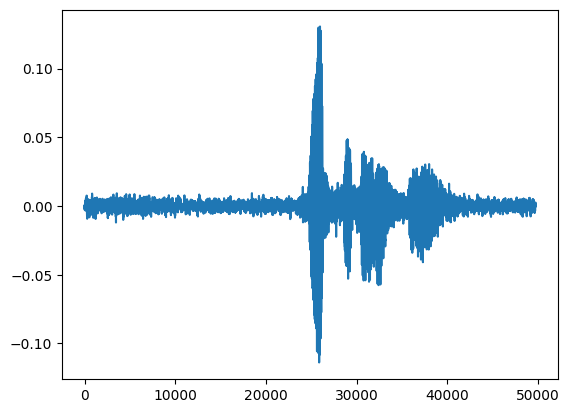

In [8]:
waveform, sample_rate, filename, label, speaker_id = val_set.__getitem__(0)
print("Shape of waveform: {}".format(waveform.size()))
print(f"Sample rate: {sample_rate} Hz, emotion label: {label}")
plt.plot(waveform.t().numpy())

In [9]:
data = IEMOCAP(root=data_dir, 
               # sessions=(1,2,), # use all
               utterance_type='scripted'
              )
all_labels = sorted(list(set(datapoint[3] for datapoint in data)))
print(all_labels)

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [10]:
labels = ['ang', 'neu', 'sad']

def label_to_index(word):
    return torch.tensor(labels.index(word), dtype=torch.int64)
def index_to_label(index):
    return labels[index]
    
data_x = []
data_y = []
for d in data:
    if d[3] in labels:
        data_x.append(d)
        data_y.append(label_to_index(d[3]))

In [11]:
train_set, test_set = train_test_split(
    data_x, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(train_set))
print("Test: %i" % len(test_set))

Train: 1519
Test: 380


In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=2):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, _, label, *_ in batch:
        length = len(waveform)
        max_length = sample_rate * max_duration_in_second
        offset = max(0, (length - max_length) // 2)
        tensors += [waveform[offset: length-offset]]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m15_iemocap.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M15_iemocap
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 64
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 9
  - 9
  residual_connection_type: concat
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 32
  pooling: max
  use_context: true
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 128
  - 128
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
       

In [15]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [16]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [17]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                              | 0.00423728813559322/10 [00:00<19:59, 120.03s/it]

Train Epoch: 1 [0/1519 (0%)]	Loss: 1.010758
Mem before-during-after: 356352 1857027072 21677568


  2%|███                                                                                                                                                                            | 0.17372881355932196/10 [00:12<10:42, 65.39s/it]

Train Epoch: 1 [320/1519 (21%)]	Loss: 1.151284
Mem before-during-after: 21677568 1213225472 21677568


  3%|██████                                                                                                                                                                          | 0.3432203389830503/10 [00:23<10:50, 67.32s/it]

Train Epoch: 1 [640/1519 (42%)]	Loss: 1.001975
Mem before-during-after: 21677568 1504416768 21677568


  5%|█████████                                                                                                                                                                       | 0.5127118644067787/10 [00:33<09:35, 60.62s/it]

Train Epoch: 1 [960/1519 (63%)]	Loss: 0.946163
Mem before-during-after: 21677568 1793970176 21677568


  7%|████████████                                                                                                                                                                    | 0.6822033898305071/10 [00:45<08:24, 54.09s/it]

Train Epoch: 1 [1280/1519 (85%)]	Loss: 0.921492
Mem before-during-after: 21677568 1040438272 21677568


 10%|█████████████████▊                                                                                                                                                               | 1.004237288135591/10 [01:02<06:53, 45.98s/it]


Test Epoch: 1	Accuracy: 219/376 (58%)

Train Epoch: 2 [0/1519 (0%)]	Loss: 0.855609
Mem before-during-after: 21673472 728207872 21677568


 12%|████████████████████▋                                                                                                                                                           | 1.1779661016949126/10 [01:14<08:43, 59.29s/it]

Train Epoch: 2 [320/1519 (21%)]	Loss: 1.121674
Mem before-during-after: 21677568 1742896128 21677568


 13%|███████████████████████▊                                                                                                                                                         | 1.347457627118641/10 [01:25<08:02, 55.72s/it]

Train Epoch: 2 [640/1519 (42%)]	Loss: 0.936339
Mem before-during-after: 21677568 1320011776 21677568


 15%|██████████████████████████▋                                                                                                                                                     | 1.5169491525423693/10 [01:35<08:06, 57.30s/it]

Train Epoch: 2 [960/1519 (63%)]	Loss: 0.935572
Mem before-during-after: 21677568 2678955008 21677568


 17%|█████████████████████████████▌                                                                                                                                                  | 1.6822033898305044/10 [01:45<08:56, 64.51s/it]

Train Epoch: 2 [1280/1519 (85%)]	Loss: 0.467340
Mem before-during-after: 21677568 1609145856 21677568


 20%|███████████████████████████████████▏                                                                                                                                            | 1.9999999999999951/10 [02:01<05:49, 43.64s/it]


Test Epoch: 2	Accuracy: 223/376 (59%)



 20%|███████████████████████████████████▎                                                                                                                                            | 2.0042372881355885/10 [02:02<06:33, 49.23s/it]

Train Epoch: 3 [0/1519 (0%)]	Loss: 0.946760
Mem before-during-after: 21673472 2061459968 21677568


 22%|██████████████████████████████████████▌                                                                                                                                          | 2.177966101694919/10 [02:13<07:12, 55.30s/it]

Train Epoch: 3 [320/1519 (21%)]	Loss: 0.472317
Mem before-during-after: 21677568 1845335040 21677568


 23%|█████████████████████████████████████████▍                                                                                                                                       | 2.343220338983063/10 [02:22<07:34, 59.39s/it]

Train Epoch: 3 [640/1519 (42%)]	Loss: 0.865419
Mem before-during-after: 21677568 1709553152 21677568


 25%|████████████████████████████████████████████▎                                                                                                                                   | 2.5169491525423937/10 [02:33<07:10, 57.59s/it]

Train Epoch: 3 [960/1519 (63%)]	Loss: 1.211801
Mem before-during-after: 21677568 1245822464 21677568


 27%|███████████████████████████████████████████████▏                                                                                                                                | 2.6822033898305375/10 [02:44<09:00, 73.84s/it]

Train Epoch: 3 [1280/1519 (85%)]	Loss: 1.101797
Mem before-during-after: 21677568 1950866944 21677568


 30%|█████████████████████████████████████████████████████                                                                                                                            | 3.000000000000045/10 [03:00<05:26, 46.70s/it]


Test Epoch: 3	Accuracy: 219/376 (58%)



 30%|████████████████████████████████████████████████████▉                                                                                                                           | 3.0084745762712317/10 [03:01<05:35, 47.99s/it]

Train Epoch: 4 [0/1519 (0%)]	Loss: 0.967292
Mem before-during-after: 21673472 1624951808 21677568


 32%|███████████████████████████████████████████████████████▊                                                                                                                        | 3.1737288135593755/10 [03:11<06:48, 59.85s/it]

Train Epoch: 4 [320/1519 (21%)]	Loss: 0.754919
Mem before-during-after: 21677568 1583468032 21677568


 33%|██████████████████████████████████████████████████████████▊                                                                                                                     | 3.3432203389831128/10 [03:21<07:53, 71.13s/it]

Train Epoch: 4 [640/1519 (42%)]	Loss: 0.394886
Mem before-during-after: 21677568 3293886976 21677568


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                   | 3.51271186440685/10 [03:32<06:10, 57.07s/it]

Train Epoch: 4 [960/1519 (63%)]	Loss: 0.655716
Mem before-during-after: 21677568 1580243456 21677568


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 3.6822033898305873/10 [03:43<06:28, 61.52s/it]

Train Epoch: 4 [1280/1519 (85%)]	Loss: 1.451519
Mem before-during-after: 21677568 2249619968 21677568


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4.000000000000094/10 [03:59<04:31, 45.20s/it]


Test Epoch: 4	Accuracy: 225/376 (59%)



 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.004237288135688/10 [03:59<04:53, 48.97s/it]

Train Epoch: 5 [0/1519 (0%)]	Loss: 0.634505
Mem before-during-after: 21673472 1788495872 21677568


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 4.173728813559425/10 [04:10<05:00, 51.52s/it]

Train Epoch: 5 [320/1519 (21%)]	Loss: 0.940983
Mem before-during-after: 21677568 1013207552 21677568


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4.3474576271187555/10 [04:20<05:10, 54.86s/it]

Train Epoch: 5 [640/1519 (42%)]	Loss: 0.913567
Mem before-during-after: 21677568 933443584 21677568


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 4.516949152542493/10 [04:29<04:49, 52.87s/it]

Train Epoch: 5 [960/1519 (63%)]	Loss: 0.776023
Mem before-during-after: 21677568 2180316672 21677568


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 4.6822033898306366/10 [04:40<05:27, 61.54s/it]

Train Epoch: 5 [1280/1519 (85%)]	Loss: 1.104369
Mem before-during-after: 21677568 2231709696 21677568


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.000000000000144/10 [04:57<03:36, 43.35s/it]


Test Epoch: 5	Accuracy: 223/376 (59%)



 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 5.008474576271331/10 [04:57<03:45, 45.15s/it]

Train Epoch: 6 [0/1519 (0%)]	Loss: 0.856896
Mem before-during-after: 21673472 1109227520 21677568


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 5.177966101695068/10 [05:08<04:32, 56.58s/it]

Train Epoch: 6 [320/1519 (21%)]	Loss: 0.886635
Mem before-during-after: 21677568 1718703616 21677568


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 5.343220338983212/10 [05:19<05:01, 64.72s/it]

Train Epoch: 6 [640/1519 (42%)]	Loss: 0.693244
Mem before-during-after: 21677568 1776556032 21677568


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 5.512711864406949/10 [05:29<04:52, 65.15s/it]

Train Epoch: 6 [960/1519 (63%)]	Loss: 0.920292
Mem before-during-after: 21677568 3153171968 21677568


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 5.68644067796628/10 [05:39<04:13, 58.73s/it]

Train Epoch: 6 [1280/1519 (85%)]	Loss: 0.638017
Mem before-during-after: 21677568 851511296 21677568


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000194/10 [05:55<02:57, 44.42s/it]


Test Epoch: 6	Accuracy: 225/376 (59%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 6.004237288135787/10 [05:55<03:08, 47.28s/it]

Train Epoch: 7 [0/1519 (0%)]	Loss: 0.562203
Mem before-during-after: 21673472 1395847680 21677568


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6.173728813559524/10 [06:06<03:47, 59.49s/it]

Train Epoch: 7 [320/1519 (21%)]	Loss: 0.921170
Mem before-during-after: 21677568 1090323456 21677568


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 6.3432203389832615/10 [06:16<03:40, 60.42s/it]

Train Epoch: 7 [640/1519 (42%)]	Loss: 0.758160
Mem before-during-after: 21677568 2081719808 21677568


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6.512711864406999/10 [06:27<03:24, 58.58s/it]

Train Epoch: 7 [960/1519 (63%)]	Loss: 1.179380
Mem before-during-after: 21677568 981611520 21677568


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6.682203389830736/10 [06:37<03:22, 60.92s/it]

Train Epoch: 7 [1280/1519 (85%)]	Loss: 0.957473
Mem before-during-after: 21677568 2475455488 21677568


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000243/10 [06:54<02:11, 43.74s/it]


Test Epoch: 7	Accuracy: 214/376 (56%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 7.00847457627143/10 [06:54<02:29, 49.84s/it]

Train Epoch: 8 [0/1519 (0%)]	Loss: 0.998007
Mem before-during-after: 21673472 2597419008 21677568


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7.1779661016951675/10 [07:04<02:32, 53.94s/it]

Train Epoch: 8 [320/1519 (21%)]	Loss: 0.998410
Mem before-during-after: 21677568 1624734208 21677568


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7.343220338983311/10 [07:14<02:41, 60.86s/it]

Train Epoch: 8 [640/1519 (42%)]	Loss: 0.909299
Mem before-during-after: 21677568 2009438720 21677568


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7.5127118644070485/10 [07:25<02:31, 61.06s/it]

Train Epoch: 8 [960/1519 (63%)]	Loss: 0.554355
Mem before-during-after: 21677568 1110441984 21677568


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7.682203389830786/10 [07:37<02:42, 70.22s/it]

Train Epoch: 8 [1280/1519 (85%)]	Loss: 0.441204
Mem before-during-after: 21677568 2876462080 21677568


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.000000000000293/10 [07:53<01:27, 43.66s/it]


Test Epoch: 8	Accuracy: 233/376 (61%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8.004237288135887/10 [07:53<01:38, 49.29s/it]

Train Epoch: 9 [0/1519 (0%)]	Loss: 0.628664
Mem before-during-after: 21673472 2080047616 21677568


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8.173728813559624/10 [08:04<01:47, 58.97s/it]

Train Epoch: 9 [320/1519 (21%)]	Loss: 0.816322
Mem before-during-after: 21677568 1460609024 21677568


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8.343220338983361/10 [08:14<01:47, 64.94s/it]

Train Epoch: 9 [640/1519 (42%)]	Loss: 1.015739
Mem before-during-after: 21677568 1816671744 21677568


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8.516949152542692/10 [08:24<01:19, 53.92s/it]

Train Epoch: 9 [960/1519 (63%)]	Loss: 0.720284
Mem before-during-after: 21677568 878900736 21677568


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8.682203389830836/10 [08:35<01:58, 89.78s/it]

Train Epoch: 9 [1280/1519 (85%)]	Loss: 0.622991
Mem before-during-after: 21677568 2590725120 21677568


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9.000000000000343/10 [08:51<00:43, 43.30s/it]


Test Epoch: 9	Accuracy: 222/376 (58%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.004237288135936/10 [08:51<00:50, 50.62s/it]

Train Epoch: 10 [0/1519 (0%)]	Loss: 0.937058
Mem before-during-after: 21673472 2728578048 21677568


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9.177966101695267/10 [09:02<00:56, 69.23s/it]

Train Epoch: 10 [320/1519 (21%)]	Loss: 0.968552
Mem before-during-after: 21677568 1853108736 21677568


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9.34322033898341/10 [09:13<00:49, 75.74s/it]

Train Epoch: 10 [640/1519 (42%)]	Loss: 0.974623
Mem before-during-after: 21677568 3153574912 21677568


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9.512711864407148/10 [09:24<00:30, 61.73s/it]

Train Epoch: 10 [960/1519 (63%)]	Loss: 0.847335
Mem before-during-after: 21677568 1269671424 21677568


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9.682203389830885/10 [09:34<00:21, 67.06s/it]

Train Epoch: 10 [1280/1519 (85%)]	Loss: 0.816050
Mem before-during-after: 21677568 2767269376 21677568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.9957627118648/10 [09:49<00:00, 43.19s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000393/10 [09:49<00:00, 58.97s/it]


Test Epoch: 10	Accuracy: 235/376 (62%)



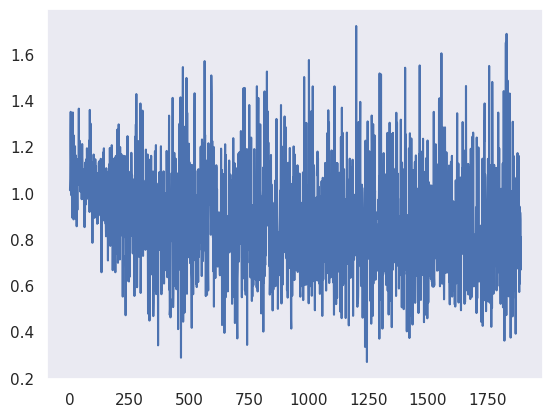

In [18]:
plt.plot(train_losses)

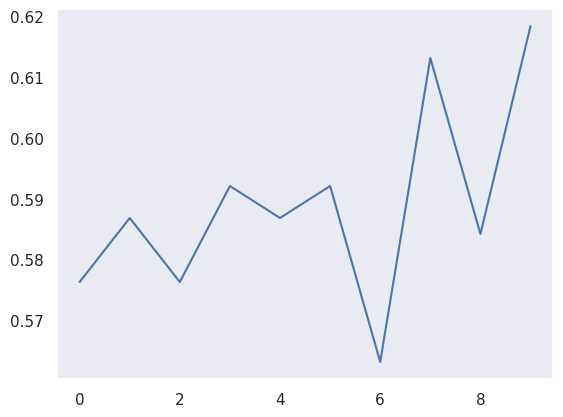

In [19]:
plt.plot(test_accuracy)

In [20]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [21]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 235/376 (0.6250)
{'acc_detail': tensor([0.7531, 0.5042, 0.5579], device='cuda:0'),
 'acc_unweighted': tensor(0.6051, device='cuda:0'),
 'acc_weighted': tensor(0.6250, device='cuda:0'),
 'f1s': tensor(0.6045, device='cuda:0'),
 'f1s_detail': tensor([0.7871, 0.4938, 0.5327], device='cuda:0'),
 'precision_detail': tensor([0.8243, 0.4839, 0.5096], device='cuda:0'),
 'recall_detail': tensor([0.7531, 0.5042, 0.5579], device='cuda:0'),
 'rocauc': tensor([0.8950, 0.7282, 0.8112], device='cuda:0'),
 'uar': tensor(0.6051, device='cuda:0'),
 'wap': tensor(0.6371, device='cuda:0')}


tensor([[122,  31,   9],
        [ 17,  60,  42],
        [  9,  33,  53]], device='cuda:0')

In [22]:
model_path = '../iemocap_label3_m12_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [23]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [24]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-6.8151e-17],
        [-5.1357e-17],
        [ 3.5581e-19],
        [-5.5916e-19],
        [-4.0766e-19],
        [ 4.2703e-19],
        [-4.5030e-17],
        [-1.5262e-17],
        [-4.4223e-19],
        [ 1.6616e-18],
        [-3.2912e-18],
        [-4.4115e-19],
        [ 6.7087e-20],
        [ 3.3355e-18],
        [ 7.1833e-19],
        [ 0.0000e+00],
        [ 5.1376e-19],
        [ 2.7736e-19],
        [ 3.2179e-19],
        [-1.6459e-19],
        [ 1.1496e-18],
        [ 7.4145e-18],
        [ 4.6568e-18],
        [-1.3803e-18],
        [ 1.5676e-18],
        [-3.0915e-18],
        [-2.0223e-17],
        [-1.4120e-19],
        [ 3.4235e-19],
        [ 3.1754e-19],
        [-3.2094e-19],
        [ 0.0000e+00],
        [ 7.3088e-17],
        [-2.9390e-17],
        [-2.2595e-18],
        [ 6.8692e-19],
        [ 4.9949e-18],
        [ 2.6919e-18],
        [-2.5136e-18],
        [ 2.9515e-19],
        [-1.1101e-19],
        [ 2.0972e-18],
        [-1

[None, None, None]

(array([6., 3., 3., 3., 3., 1., 3., 2., 2., 2., 2., 0., 4., 0., 4., 0., 0.,
        4., 0., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 2.]),
 array([0.        , 0.01135363, 0.02270726, 0.0340609 , 0.04541453,
        0.05676816, 0.06812179, 0.07947542, 0.09082905, 0.10218268,
        0.11353631, 0.12488995, 0.13624358, 0.14759721, 0.15895084,
        0.17030448, 0.1816581 , 0.19301173, 0.20436536, 0.215719  ,
        0.22707263, 0.23842625, 0.24977989, 0.26113352, 0.27248716,
        0.28384078, 0.29519442, 0.30654806, 0.31790167, 0.32925531,
        0.34060895, 0.35196257, 0.36331621, 0.37466982, 0.38602346,
        0.3973771 , 0.40873072, 0.42008436, 0.431438  , 0.44279161,
        0.45414525]),
 <BarContainer object of 40 artists>)

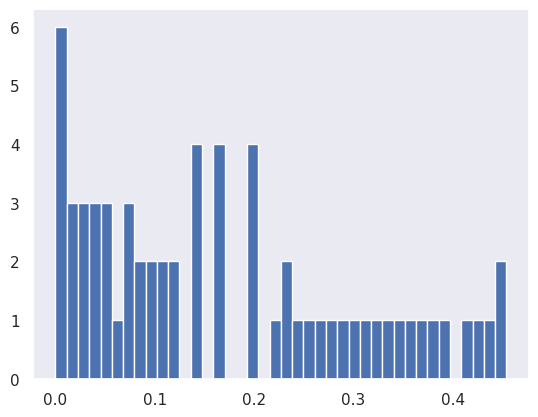

In [25]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  6., 49.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-7.29764042e-16, -6.87112227e-16, -6.44460412e-16, -6.01808545e-16,
        -5.59156730e-16, -5.16504915e-16, -4.73853101e-16, -4.31201259e-16,
        -3.88549418e-16, -3.45897604e-16, -3.03245789e-16, -2.60593948e-16,
        -2.17942120e-16, -1.75290292e-16, -1.32638464e-16, -8.99866429e-17,
        -4.73348150e-17, -4.68298957e-18,  3.79688375e-17,  8.06206621e-17,
         1.23272490e-16,  1.65924318e-16,  2.08576146e-16,  2.51227960e-16,
         2.93879802e-16,  3.36531616e-16,  3.79183457e-16,  4.21835272e-16,
         4.64487087e-16,  5.07138954e-16,  5.49790769e-16,  5.92442584e-16,
         6.35094398e-16,  6.77746213e-16,  7.20398081e-16,  7.63049895e-16,
         8.05701710e-16,  8.48353525e-16,  8.91005392e-16,  9.33657207e-16,
      

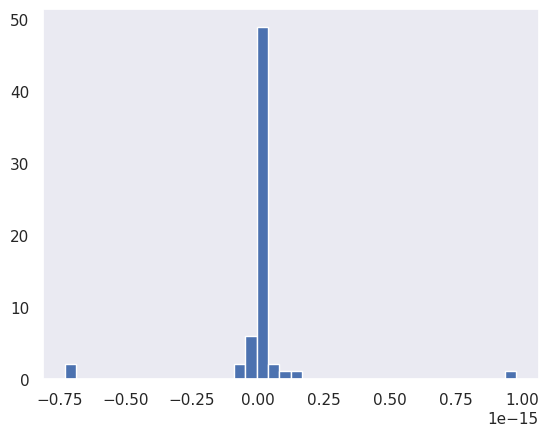

In [26]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

/tmp/ipykernel_3766717/1402059949.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_3766717/1402059949.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([1., 0., 0., 0., 0., 1., 5., 2., 2., 3., 0., 1., 0., 2., 2., 2., 1.,
        2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-44.14829254, -43.90865326, -43.66901398, -43.42937851,
        -43.18973923, -42.95009995, -42.71046066, -42.47082138,
        -42.23118591, -41.99154663, -41.75190735, -41.51226807,
        -41.27262878, -41.03299332, -40.79335403, -40.55371475,
        -40.31407547, -40.07443619, -39.83480072, -39.59516144,
        -39.35552216, -39.11588287, -38.87624359, -38.63660812,
        -38.39696884, -38.15732956, -37.91769028, -37.67805099,
        -37.43841553, -37.19877625, -36.95913696, -36.71949768,
        -36.4798584 , -36.24022293, -36.00058365, -35.76094437,
        -35.52130508, -35.2816658 , -35.04203033, -34.80239105,
        -34.56275177]),
 <BarContainer object of 40 artists>)

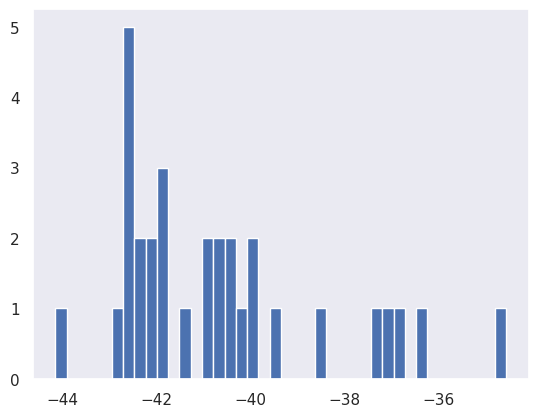

In [27]:
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([2., 1., 3., 2., 3., 2., 4., 3., 5., 1., 4., 3., 2., 3., 2., 3., 2.,
        2., 2., 2., 1., 3., 0., 2., 1., 0., 1., 0., 2., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1.]),
 array([0.0074629 , 0.00925725, 0.0110516 , 0.01284595, 0.0146403 ,
        0.01643465, 0.01822901, 0.02002336, 0.02181771, 0.02361206,
        0.02540641, 0.02720076, 0.02899511, 0.03078946, 0.03258381,
        0.03437816, 0.03617251, 0.03796686, 0.03976121, 0.04155556,
        0.04334991, 0.04514426, 0.04693861, 0.04873297, 0.05052732,
        0.05232166, 0.05411602, 0.05591037, 0.05770472, 0.05949907,
        0.06129342, 0.06308777, 0.06488212, 0.06667647, 0.06847082,
        0.07026517, 0.07205952, 0.07385387, 0.07564823, 0.07744257,
        0.07923692]),
 <BarContainer object of 40 artists>)

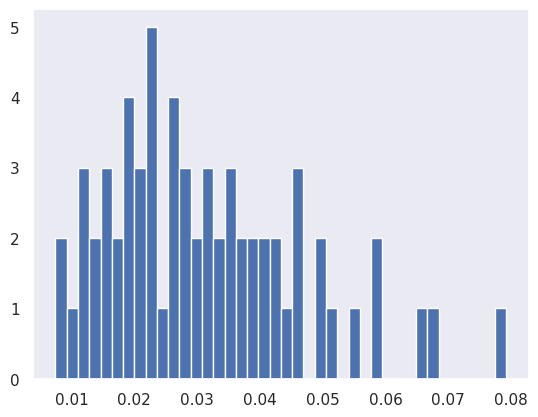

In [28]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0., 57.,  2.,  1.,  0.,  0.,  0.,  0.,
         1.]),
 array([-6.98305503e-16, -6.77013212e-16, -6.55720921e-16, -6.34428577e-16,
        -6.13136287e-16, -5.91843996e-16, -5.70551705e-16, -5.49259362e-16,
        -5.27967071e-16, -5.06674780e-16, -4.85382490e-16, -4.64090199e-16,
        -4.42797882e-16, -4.21505564e-16, -4.00213274e-16, -3.78920957e-16,
        -3.57628666e-16, -3.36336375e-16, -3.15044058e-16, -2.93751767e-16,
        -2.72459450e-16, -2.51167159e-16, -2.29874842e-16, -2.08582551e-16,
        -1.87290248e-16, -1.65997944e-16, -1.44705640e-16, -1.23413336e-16,
        -1.02121038e-16, -8.08287344e-17, -5.95364371e-17, -3.82441331e-17,
        -1.69518292e-17,  4.34047310e-18,  2.56327754e-17,  4.69250760e-17,
         6.82173800e-17,  8.95096839e-17,  1.10801981e-16,  1.32094285e-16,
      

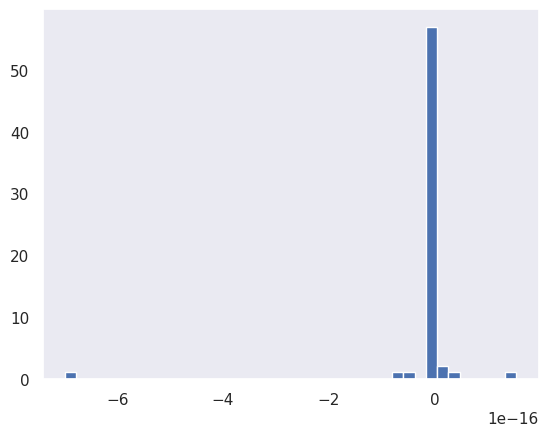

In [29]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

/tmp/ipykernel_3766717/1421197636.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths.flatten()), bins=40)


(array([2., 1., 0., 0., 0., 0., 2., 0., 3., 0., 2., 2., 1., 3., 1., 1., 1.,
        1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-45.2819519 , -45.0602417 , -44.83853149, -44.6168251 ,
        -44.3951149 , -44.17340469, -43.95169449, -43.72998428,
        -43.50827408, -43.28656769, -43.06485748, -42.84314728,
        -42.62143707, -42.39972687, -42.17801666, -41.95631027,
        -41.73460007, -41.51288986, -41.29117966, -41.06946945,
        -40.84776306, -40.62605286, -40.40434265, -40.18263245,
        -39.96092224, -39.73921204, -39.51750565, -39.29579544,
        -39.07408524, -38.85237503, -38.63066483, -38.40895462,
        -38.18724823, -37.96553802, -37.74382782, -37.52211761,
        -37.30040741, -37.0786972 , -36.85699081, -36.63528061,
        -36.4135704 ]),
 <BarContainer object of 40 artists>)

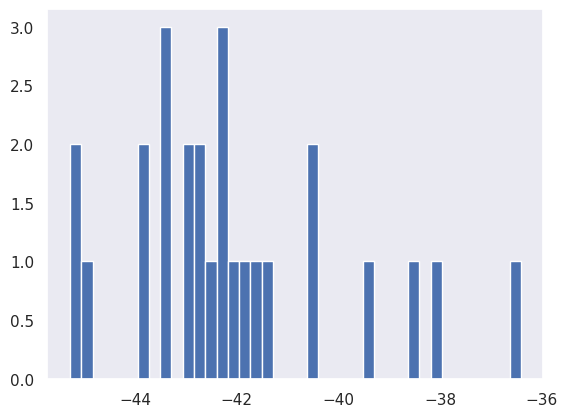

In [30]:
plt.hist(np.log(bandwidths.flatten()), bins=40)

(array([ 4.,  1.,  7., 18., 29.,  5.,  0.,  0.,  0.,  1.,  5., 10., 28.,
        81., 43., 39., 25., 21., 15., 38., 11.,  1.,  2.,  0.,  0.,  0.,
         1.,  5., 18., 33.,  8., 10., 17., 18., 14.,  5.,  4., 15., 32.,
        12.]),
 array([-0.04822208, -0.0212993 ,  0.00562347,  0.03254624,  0.05946902,
         0.08639179,  0.11331457,  0.14023735,  0.16716012,  0.19408289,
         0.22100566,  0.24792844,  0.2748512 ,  0.301774  ,  0.32869676,
         0.35561955,  0.38254231,  0.4094651 ,  0.43638787,  0.46331063,
         0.49023342,  0.51715618,  0.54407895,  0.57100171,  0.59792453,
         0.62484729,  0.65177006,  0.67869282,  0.70561564,  0.7325384 ,
         0.75946116,  0.78638393,  0.81330669,  0.84022951,  0.86715227,
         0.89407504,  0.9209978 ,  0.94792056,  0.97484338,  1.00176609,
         1.02868891]),
 <BarContainer object of 40 artists>)

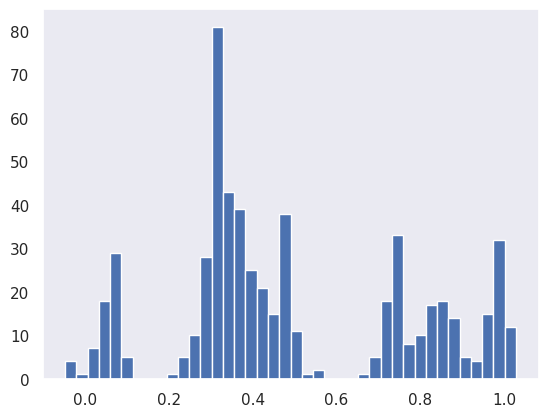

In [31]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   2.,   0.,   7.,
          6.,   4.,   9.,  17.,  26.,  35.,  55.,  97., 142.,  61.,  27.,
         19.,  15.,   9.,   7.,   5.,   5.,   3.,   5.,   3.,   3.,   1.,
          3.,   1.,   1.,   0.,   2.,   0.,   1.]),
 array([-0.00473086, -0.00448832, -0.00424577, -0.00400323, -0.00376068,
        -0.00351813, -0.00327559, -0.00303304, -0.0027905 , -0.00254795,
        -0.0023054 , -0.00206286, -0.00182031, -0.00157776, -0.00133522,
        -0.00109267, -0.00085013, -0.00060758, -0.00036503, -0.00012249,
         0.00012006,  0.00036261,  0.00060515,  0.0008477 ,  0.00109024,
         0.00133279,  0.00157534,  0.00181788,  0.00206043,  0.00230297,
         0.00254552,  0.00278807,  0.00303061,  0.00327316,  0.00351571,
         0.00375825,  0.0040008 ,  0.00424334,  0.00448589,  0.00472844,
         0.00497098]),
 <BarContainer object of 40 artists>)

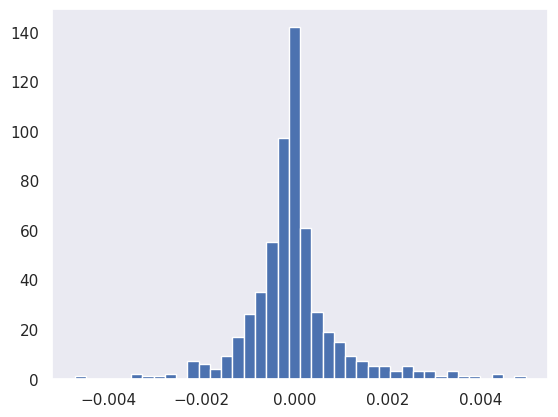

In [32]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

/tmp/ipykernel_3766717/569063560.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(window_params.flatten()), bins=40)


(array([ 3.,  2.,  1.,  5.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  2.,  5., 11., 13., 23., 33., 33., 32., 29., 22.,
        13.]),
 array([-28.87313461, -28.28390884, -27.69468498, -27.10545921,
        -26.51623535, -25.92700958, -25.33778572, -24.74855995,
        -24.15933609, -23.57011032, -22.98088455, -22.39166069,
        -21.80243492, -21.21321106, -20.62398529, -20.03476143,
        -19.44553566, -18.8563118 , -18.26708603, -17.67786026,
        -17.0886364 , -16.49941063, -15.91018677, -15.320961  ,
        -14.73173618, -14.14251137, -13.55328655, -12.96406174,
        -12.37483692, -11.78561211, -11.19638729, -10.60716248,
        -10.01793671,  -9.42871189,  -8.83948708,  -8.25026226,
         -7.66103745,  -7.07181263,  -6.48258734,  -5.89336252,
         -5.30413771]),
 <BarContainer object of 40 artists>)

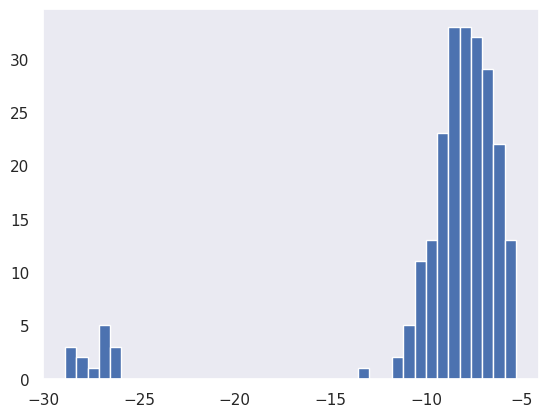

In [33]:
plt.hist(np.log(window_params.flatten()), bins=40)

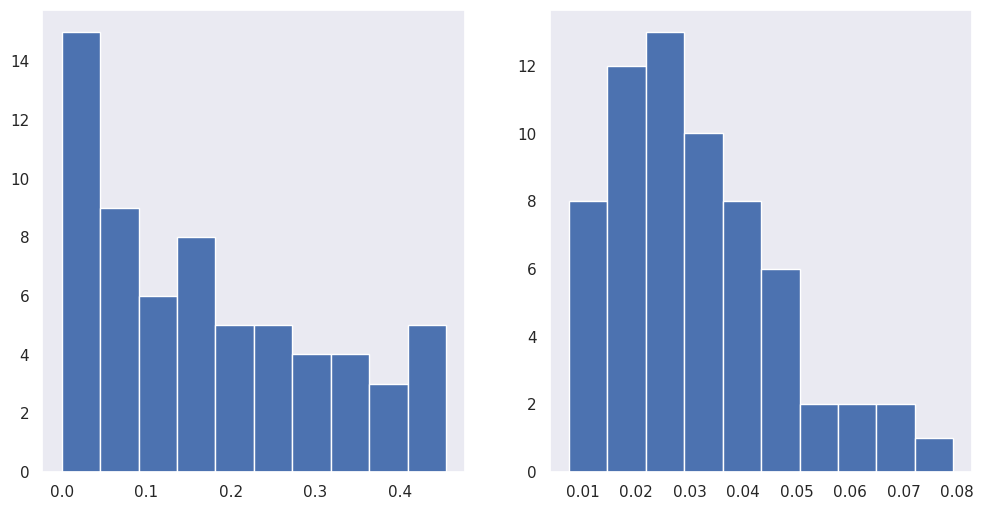

In [35]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sample_rate
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


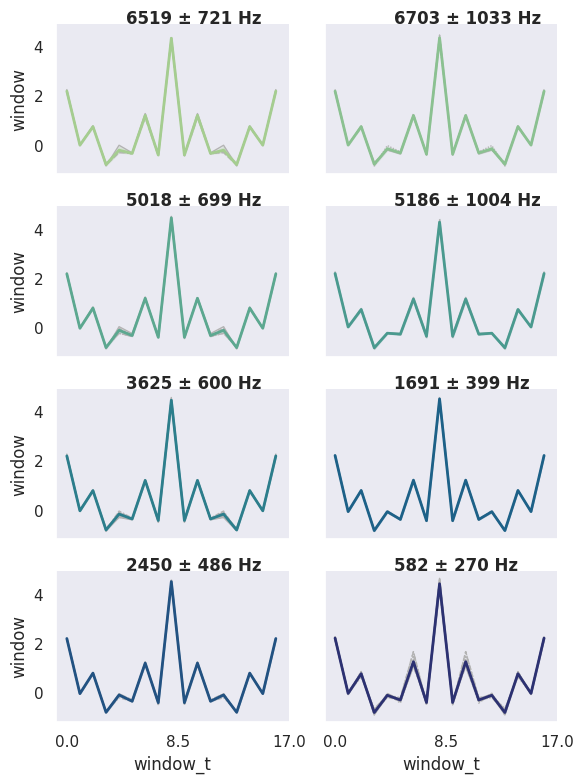

In [36]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


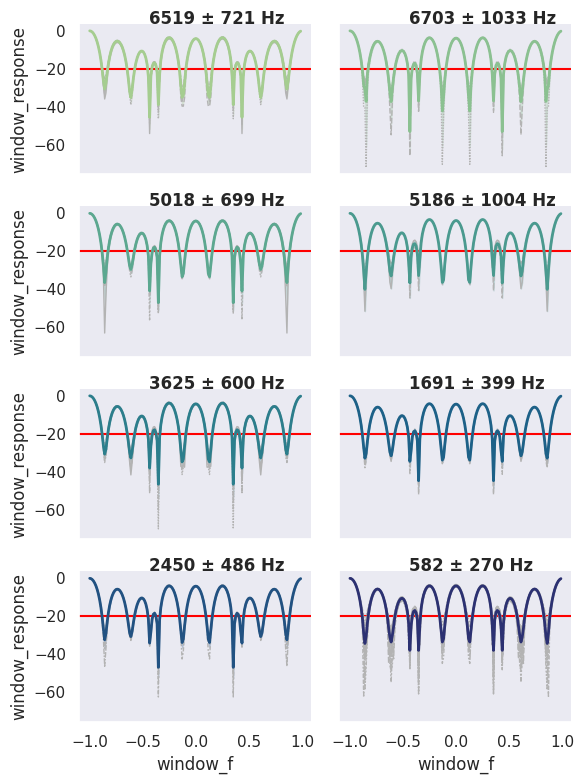

In [37]:
filtviz.visualize_filters(filter_domain='freq')

In [38]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        ...,
        [0.3697, 0.3697, 0.3697,  ..., 0.3697, 0.3697, 0.3697],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108],
        [0.4541, 0.4541, 0.4541,  ..., 0.4541, 0.4541, 0.4541]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
        [0.0087, 0.0087, 0.0087,  ..., 0.0087, 0.0087, 0.0087],
        [0.0102, 0.0102, 0.0102,  ..., 0.0102, 0.0102, 0.0102],
        ...,
        [0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
        [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
        [0.0459, 0.0459, 0.0459,  ..., 0.0459, 0.0459, 0.0459]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

(array([384., 192., 192., 192., 192.,  64., 192., 128., 128., 128., 128.,
          0., 256.,   0., 256.,   0.,   0., 256.,   0.,  64., 128.,  64.,
         64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,
         64.,  64.,   0.,  64.,  64.,  64., 128.]),
 array([0.        , 0.01135363, 0.02270726, 0.0340609 , 0.04541453,
        0.05676816, 0.06812179, 0.07947542, 0.09082905, 0.10218268,
        0.11353631, 0.12488995, 0.13624358, 0.14759721, 0.15895084,
        0.17030448, 0.1816581 , 0.19301173, 0.20436536, 0.215719  ,
        0.22707263, 0.23842625, 0.24977989, 0.26113352, 0.27248716,
        0.28384078, 0.29519442, 0.30654806, 0.31790167, 0.32925531,
        0.34060895, 0.35196257, 0.36331621, 0.37466982, 0.38602346,
        0.3973771 , 0.40873072, 0.42008436, 0.431438  , 0.44279161,
        0.45414525]),
 <BarContainer object of 40 artists>)

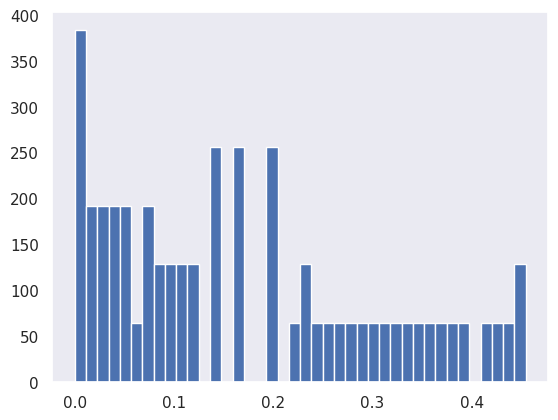

In [39]:
named_params2 = [p for p in layer2.named_parameters()]
lowbands2 = named_params2[0][1].detach().cpu().numpy()
plt.hist(lowbands2.flatten(), bins=40)

/tmp/ipykernel_3766717/2621672499.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

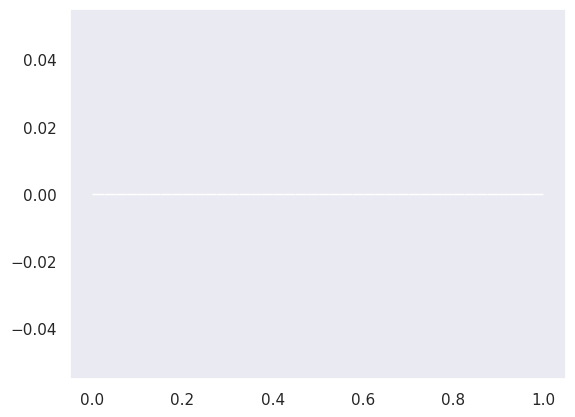

In [40]:
grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

In [41]:
grad_log

array([], dtype=float32)

(array([8192.,    0., 4096.,    0.,    0., 4096.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 4096.,    0.,    0.,
           0.,    0.,    0., 4096.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 8192.,    0.,    0.,    0.,
           0.,    0.,    0., 4096.]),
 array([0.09262639, 0.11523473, 0.13784306, 0.16045138, 0.18305972,
        0.20566805, 0.22827637, 0.25088471, 0.27349305, 0.29610136,
        0.3187097 , 0.34131804, 0.36392635, 0.38653469, 0.40914303,
        0.43175137, 0.45435968, 0.47696802, 0.49957636, 0.52218467,
        0.54479301, 0.56740135, 0.59000969, 0.61261803, 0.63522631,
        0.65783465, 0.68044299, 0.70305133, 0.72565967, 0.74826801,
        0.77087629, 0.79348463, 0.81609297, 0.83870131, 0.86130965,
        0.88391799, 0.90652633, 0.92913461, 0.95174295, 0.97435129,
        0.99695963]),
 <BarContainer object of 40 artists>)

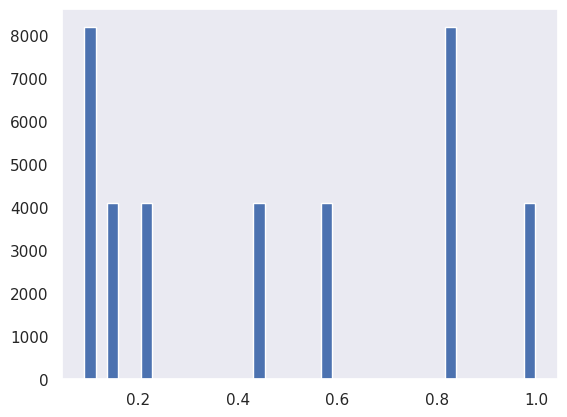

In [42]:
winparams2 = named_params2[2][1].detach().cpu().numpy()
plt.hist(winparams2.flatten(), bins=40)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0., 36864.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.]),
 array([-0.5       , -0.47499999, -0.44999999, -0.42500001, -0.40000001,
        -0.375     , -0.34999999, -0.32499999, -0.30000001, -0.27500001,
        -0.25      , -0.22499999, -0.2       , -0.175     , -0.15000001,
        -0.125     , -0.1       , -0.075     , -0.05      , -0.025     ,
         0.        ,  0.025     ,  0.05      ,  0.075     ,  0.1       ,
         0.125     ,  0.15000001,  0.175     ,  0.2       ,  0.22499999,
         0.25      ,  0.27500001,  0.30000001,  0.32499999,  0.34999999,
         0.375     ,  0.40000001,  0.42500001,  0.44999999,  0.47499999,
         0.5       ]),
 <BarContainer object of 40 art

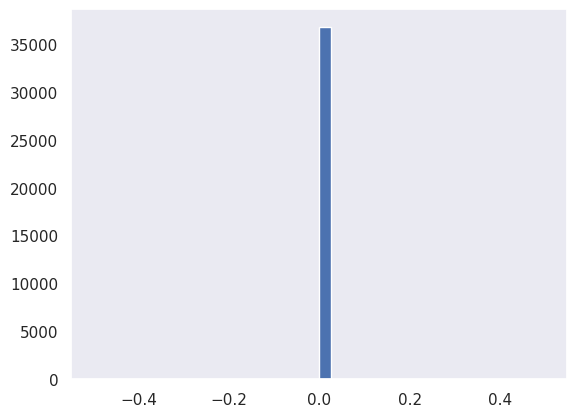

In [43]:
winparams2_grad = named_params2[2][1].grad.detach().cpu().numpy()
plt.hist(winparams2_grad.flatten(), bins=40)

downsample_factor: 4 => new_sample_rate: 4000


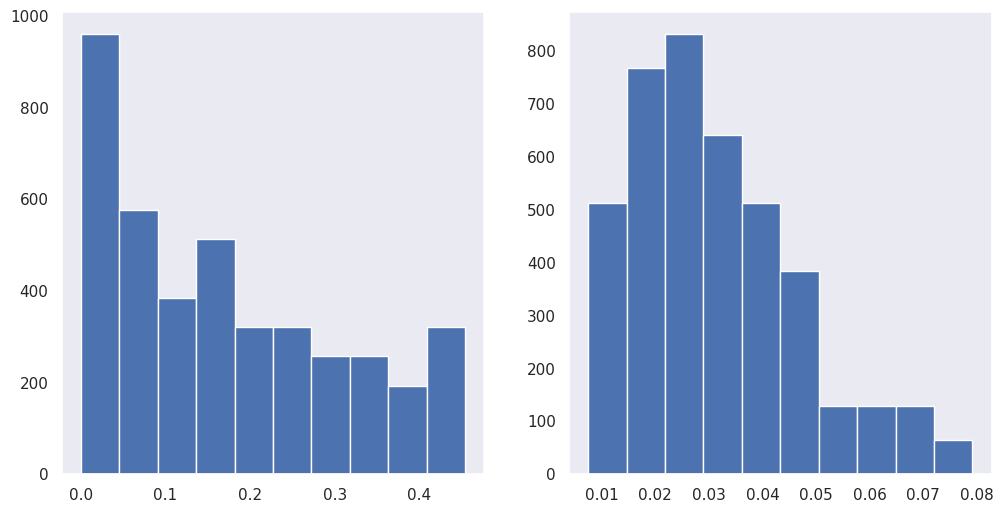

In [45]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sample_rate // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


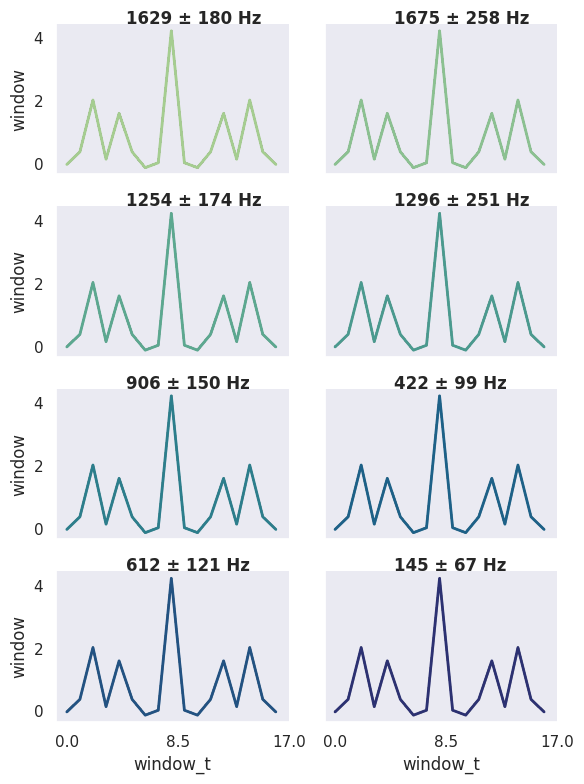

In [46]:
filtviz2.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


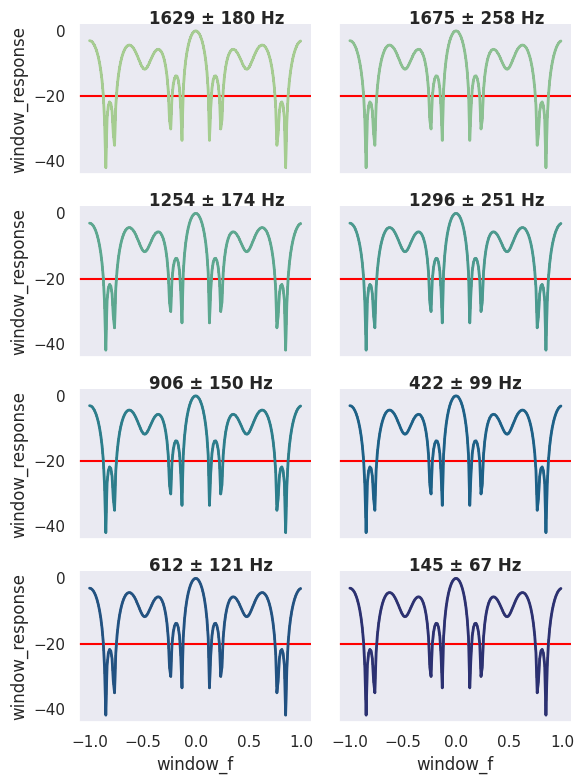

In [47]:
filtviz2.visualize_filters('freq')

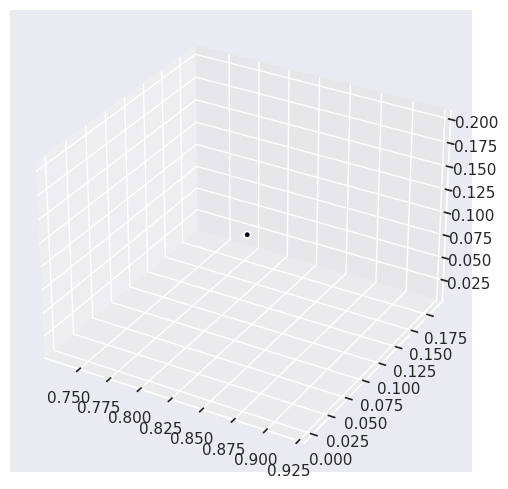

In [48]:
filtviz2.visualize_window_params()

In [49]:
model.to("cpu")

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(64, 32, batch_first=True)
  )
  (cls_hea

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()